Ridge:
  Training RMSE: 0.1079
  Validation RMSE: 0.1338
  CV RMSE: 0.1291
--------------------------------------------------
Lasso:
  Training RMSE: 0.1179
  Validation RMSE: 0.1370
  CV RMSE: 0.1280
--------------------------------------------------


/Users/chrisjagielski/Documents/git/ai_predictive_model_for_house_prices/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.671e-02, tolerance: 1.781e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/chrisjagielski/Documents/git/ai_predictive_model_for_house_prices/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.764e-01, tolerance: 1.891e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Users/chrisjagielski/Documents/git/ai_predictive_model_for_house_prices/venv/lib/python3.7/site-packages/sklearn/linear

ElasticNet:
  Training RMSE: 0.1103
  Validation RMSE: 0.1347
  CV RMSE: 0.1276
--------------------------------------------------
RandomForest:
  Training RMSE: 0.0534
  Validation RMSE: 0.1479
  CV RMSE: 0.1451
--------------------------------------------------
GradientBoosting:
  Training RMSE: 0.0774
  Validation RMSE: 0.1338
  CV RMSE: 0.1282
--------------------------------------------------
XGBoost:
  Training RMSE: 0.1056
  Validation RMSE: 0.1700
  CV RMSE: 0.1580
--------------------------------------------------


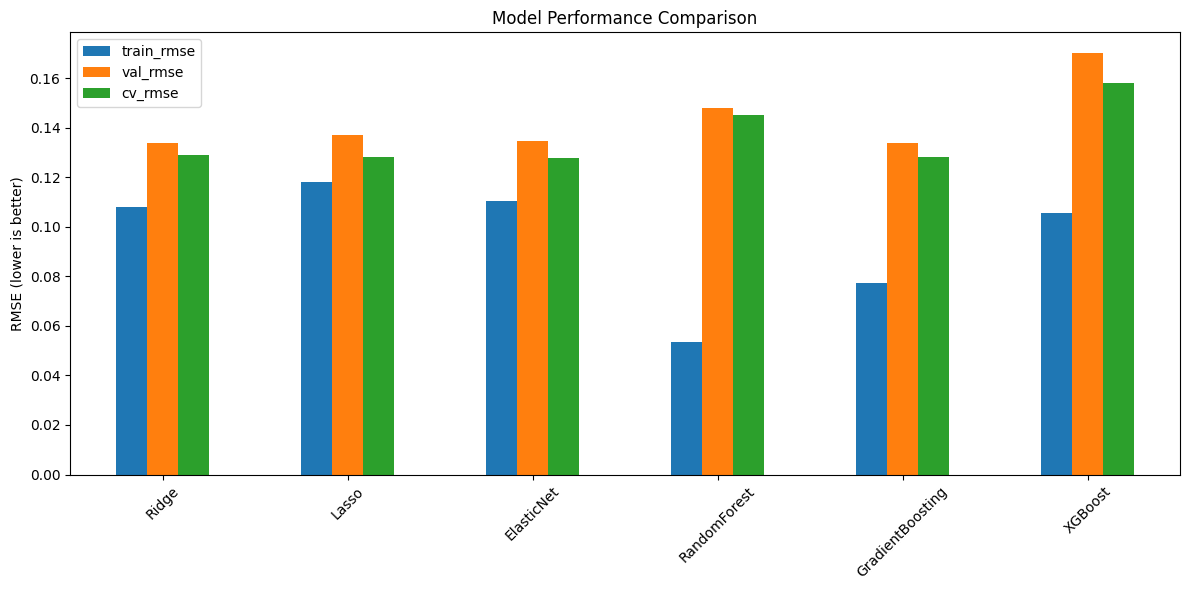

Best model: Ridge


In [1]:
# For building and evaluating models

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb  # pip install xgboost if needed
import matplotlib.pyplot as plt
import seaborn as sns

# Load processed data
train = pd.read_csv('data/processed_train.csv')
test = pd.read_csv('data/processed_test.csv')

# Separate features and target
X = train.drop(['Id', 'SalePrice'], axis=1)
y = train['SalePrice']
test_ids = test['Id']
test = test.drop('Id', axis=1)

# Create train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define evaluation function
def rmse_cv(model, X=X, y=y):
    rmse = np.sqrt(-cross_val_score(model, X, y, 
                                   scoring="neg_mean_squared_error", 
                                   cv=5))
    return rmse

# Try multiple models
models = {
    "Ridge": Ridge(alpha=10),
    "Lasso": Lasso(alpha=0.001),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    cv_rmse = rmse_cv(model).mean()
    
    results[name] = {
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'cv_rmse': cv_rmse
    }
    
    print(f"{name}:")
    print(f"  Training RMSE: {train_rmse:.4f}")
    print(f"  Validation RMSE: {val_rmse:.4f}")
    print(f"  CV RMSE: {cv_rmse:.4f}")
    print("-" * 50)

# Visualize model performance
performance = pd.DataFrame(results).T
fig, ax = plt.subplots(figsize=(12, 6))
performance[['train_rmse', 'val_rmse', 'cv_rmse']].plot(kind='bar', ax=ax)
plt.title('Model Performance Comparison')
plt.ylabel('RMSE (lower is better)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Select best model (based on validation performance)
best_model_name = min(results, key=lambda x: results[x]['val_rmse'])
best_model = models[best_model_name]
print(f"Best model: {best_model_name}")

# Feature importance for the best model (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
    plt.title(f'Top 20 Important Features - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 most important features:")
    print(feature_importances.head(10))

# Make predictions on test data
test_predictions = best_model.predict(test)

# For Kaggle: Convert predictions back from log scale
test_predictions_exp = np.expm1(test_predictions)

# Create submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_predictions_exp
})
submission.to_csv('submission.csv', index=False)